In [1]:
import matplotlib
matplotlib.use("Pdf")
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# set matplotlib parameters
params = {'backend': 'ps',
          'axes.labelsize': 13,
          'font.size': 13,
          'legend.fontsize': 13,
          'xtick.labelsize': 13,
          'ytick.labelsize': 13,
          'text.usetex': False,
          'text.latex.preamble': "\\usepackage{mathpazo}, \\usepackage{amsmath}"}
plt.rcParams.update(params)

import warnings 
warnings.filterwarnings("ignore") #ignore some matplotlib warnings

# numpy
import numpy as np

# Multiplet analysis & particle number histograms

Utilizing the cthyb functionality to measure the [many body density matrix](https://triqs.github.io/cthyb/latest/guide/static_observables_notebook.html), it is possible to analyze the multiplet structure of the impurity states, e.g. occupation probabilities of eigenstates, find the according particle number, and obtaining the spin state of those eigenstates. In principle all observables can be examined that are good quantum numbers of the system. More information of the measurement of the density matrix in cthyb can be found here: [cthyb measure static observables](https://triqs.github.io/cthyb/latest/guide/static_observables_notebook.html)

This tutorial will demonstrate how to analyze the multiplet structure from a measured density matrix and the `h_loc_diag` object of the solver. More information on how to measure those properties please take a look first [here](https://triqs.github.io/cthyb/latest/guide/static_observables_notebook.html).

Let us consider a single-orbital Anderson impurity problem. At first, we import all necessary modules, define some input parameters and construct a ctyhb Solver object in the usual way:

In [2]:
from h5 import HDFArchive
from triqs.gf.descriptors import Fourier, InverseFourier
from triqs.gf import Gf, MeshImFreq, iOmega_n, inverse, GfImTime, BlockGf, Wilson
from triqs.operators import c, c_dag, n

# redirect ctyhb c++ output to notebook
from triqs.utility.redirect import start_redirect
start_redirect()

from triqs_cthyb.solver import Solver

Starting run with 1 MPI rank(s) at : 2020-08-06 08:28:01.161945


In [3]:
# Parameters
D = 1.0         # Half-bandwidth of the bath
V = 0.2         # Hybridisation amplitude
U = 4.0         # Coulomb interaction
e_f = -U/2      # Local energy level
beta = 50       # Inverse temperature

# Construct the impurity solver with the inverse temperature
# and the structure of the Green's functions
S = Solver(beta = beta, gf_struct = [ ('up',[0]), ('down',[0]) ])

# Initialize the non-interacting Green's function S.G0_iw
# External magnetic field introduces Zeeman energy splitting between
# different spin components
S.G0_iw['up']   << inverse(iOmega_n - e_f - V**2 * Wilson(D))
S.G0_iw['down'] << inverse(iOmega_n - e_f - V**2 * Wilson(D))

# setting up a local interaction Hamiltonian
h_int = U * n('up',0) * n('down',0)

Next, we instruct the ``solve`` function to accumulate the density matrix by passing the solver parameters ``measure_density_matrix = True`` and ``use_norm_as_weight = True``. See also [cthyb solver parameters](https://triqs.github.io/cthyb/latest/reference/solve_parameters.html) for more information.

Now we run the solver:

In [4]:
# Run the solver
S.solve(h_int = h_int,                  # interaction Hamiltonian
        n_cycles  = 500000,             # Number of QMC cycles
        length_cycle = 200,             # Length of one cycle
        n_warmup_cycles = 10000,        # Warmup cycles
        measure_density_matrix = True,  # Measure the reduced density matrix
        use_norm_as_weight = True)      # Required to measure the density matrix


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
-2*c_dag('down',0)*c('down',0) + -2*c_dag('up',0)*c('up',0) + 4*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
08:28:01   9% ETA 00:00:00 cycle 930 of 10000



Accumulating ...
08:28:02   0% ETA 00:00:51 cycle 962 of 500000
08:28:04   4% ETA 00:00:50 cycle 20339 of 500000
08:28:06   8% ETA 00:00:47 cycle 44592 of 500000
08:28:10  14% ETA 00:00:44 cycle 74836 of 500000
08:28:14  22% ETA 00:00:40 cycle 112739 of 500000
08:28:19  32% ETA 00:00:35 cycle 160082 of 500000
08:28:25  43% ETA 00:00:29 cycle 219259 of 500000
08:28:32  58% ETA 00:00:21 cycle 293192 of 500000
08:28:42  77% ETA 00:00:11 cycle 385822 of 500000


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure            

### Analysis of results

Next we do the actual analysis of the multiplet structure. First we need to setup the operators, that we want to measure:

In [5]:
from triqs.operators.util import make_operator_real
from triqs.operators.util.observables import S_op, S2_op
from triqs.atom_diag import quantum_number_eigenvalues
import functools

Here, we are going to take a look at $S_z, \ S^2,$ and $N$. The two central objects we need for the analysis are:

In [6]:
# accumulated many body density matrix
rho = S.density_matrix
# the atom diag object containing information about the H_loc entering the solver
h_loc_diag = S.h_loc_diagonalization

To evaluate the expectation values we first create the operators:

In [7]:
# first get fundamental operators of H_loc from atom_diag object
occ_operators = []
for op in h_loc_diag.fops:
    occ_operators.append( n(op[0], op[1]) )

# construct total occupation operator from list
N_op = functools.reduce(lambda x,y : x+y,occ_operators)

# create S2 and Sz operator
spin_names = ['up', 'down']
orb_names = [0]

# The spin operators are created from orbital and spin names
# the flag off_diag determines if blocks of Gf are down_0 / up_0 ,
# or down / up 
S2 = S2_op(spin_names, orb_names, off_diag=True)
Sz=S_op('z', spin_names, orb_names, off_diag=True)

Next we evaluate the operators in the impurity eigenstates by using the [triqs.atom_diag](https://triqs.github.io/triqs/latest/documentation/manual/triqs/atom_diag/contents.html) function [quantum_number_eigenvalues](https://triqs.github.io/triqs/latest/documentation/cpp_api/triqs/atom_diag/quantum_number_eigenvalues.html). The object will be sorted by the subspaces contained in h_loc_diag:

In [8]:
# get eigenvalues of S2 and Sz
S2_states = quantum_number_eigenvalues(S2, h_loc_diag)
Sz_states = quantum_number_eigenvalues(Sz, h_loc_diag)

# get particle numbers from h_loc_diag
particle_numbers = quantum_number_eigenvalues(N_op, h_loc_diag)
N_max = int(max(map(max, particle_numbers)))

In [9]:
print(particle_numbers)

[array([1.]), array([1.]), array([0.]), array([2.])]


One can see, that `particle_numbers` contains now 4 numpy arrays, representing the 4 subspaces of the impurity problem. Those are actually identified by different particle numbers $0,1,$ and $2$. Each array has the size of number of eigenstates in that particular subspace, here just 1 per particle number.

Now we can use this information and correlated it with the probabilities of the states given in `rho` to obtain particle number occupation histograms etc. This information will be stored in multiplet occupation.

In [10]:
multiplet_occ = np.zeros(N_max + 1)

# we loop through all subspaces, which are just indexed as integers
for sub in range(0,h_loc_diag.n_subspaces):   

    print("subspace No.:", sub)

    # first get fock space spanning the subspace
    fs_states = []
    for ind, fs in enumerate(h_loc_diag.fock_states[sub]):
        # get state in binary representation
        state =int(bin(int(fs))[2:])
        fmt='{0:0'+str(N_max)+'d}'
        fs_states.append("|"+fmt.format(state)+">")

    # now we loop over all eigenstates within the subspace
    for ind in range(h_loc_diag.get_subspace_dim(sub)):

        # get particle number
        # carefully here to not cast to int as the particle number
        # can be something like 1.999999996 and would get then 1! 
        particle_number = int(round(particle_numbers[sub][ind]))
        # here you can see that the object obtained from quanquantum_number_eigenvalues
        # is structured in the same way as h_loc_diag
        
        # get spin operator values in the same waya
        ms=Sz_states[sub][ind]
        s_square=S2_states[sub][ind]
       
        # energy of state
        eng=h_loc_diag.energies[sub][ind]

        # probability that this state is occupied is obtained from rho
        prob = rho[sub][ind,ind]
        
        # add to multiplet histogram sorted by particle number
        multiplet_occ[particle_number] += prob
        
        # construct eigenvector in fock state basis by rotation 
        ev_state = ''
        for i, elem in enumerate(h_loc_diag.unitary_matrices[sub][:,ind]):
            ev_state += ' {:+1.4f}'.format(elem)+fs_states[i]

        # print info obtained
        print("EV No:", ind,
              ", N=",particle_number,
              ", E="+"{:1.5f}".format(eng) ,
              ", prob:"+"{:1.5f}".format(prob),
              ", S(S+1): "+"{:1.2f}".format(s_square),
              ", ms: "+"{:1.2f}".format(ms),
              ",\nEVs:", ev_state)
        
    print('----')

print('multiplet occupation by particle number: \n', multiplet_occ)
print('sum of multiplet occ: '+"{:1.5f}".format(np.sum(multiplet_occ)))

subspace No.: 0
EV No: 0 , N= 1 , E=0.00000 , prob:0.49540 , S(S+1): 0.75 , ms: 0.50 ,
EVs:  +1.0000|01>
----
subspace No.: 1
EV No: 0 , N= 1 , E=0.00000 , prob:0.49746 , S(S+1): 0.75 , ms: -0.50 ,
EVs:  +1.0000|10>
----
subspace No.: 2
EV No: 0 , N= 0 , E=2.00000 , prob:0.00354 , S(S+1): 0.00 , ms: 0.00 ,
EVs:  +1.0000|00>
----
subspace No.: 3
EV No: 0 , N= 2 , E=2.00000 , prob:0.00360 , S(S+1): 0.00 , ms: 0.00 ,
EVs:  +1.0000|11>
----
multiplet occupation by particle number: 
 [0.00353889 0.99285879 0.00360232]
sum of multiplet occ: 1.00000


## plot particle number histogram

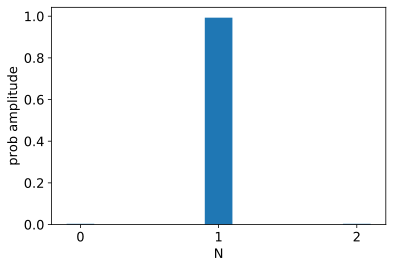

In [11]:
fig, (ax1) = plt.subplots(1,1,figsize=(6,4))

ax1.bar(range(0,len(multiplet_occ)) ,multiplet_occ, width=0.2)


ax1.set_xlabel(r'N')
ax1.set_ylabel(r'prob amplitude')

ax1.set_xticks(list(range(0,len(multiplet_occ))))        

plt.show()

## More complex example

This example was of course very simple. Here we also provide a simple function doing the analysis with the exact steps, with a few extra checks:

In [12]:
def get_multiplet_occ(rho, h_loc_diag, orb_names, spin_names = ['up','down'], off_diag = True):
    
    # get fundamental operators from atom_diag object
    occ_operators = []
    for op in h_loc_diag.fops:
        occ_operators.append( n(op[0], op[1]) )
    
    # create S2 and Sz operator
    S2 = S2_op(spin_names, orb_names, off_diag=off_diag)
    S2 = make_operator_real(S2)
    
    Sz=S_op('z', spin_names, orb_names, off_diag=off_diag)
    Sz = make_operator_real(Sz)
    
    # get eigenvalues
    S2_states = quantum_number_eigenvalues(S2, h_loc_diag)
    Sz_states = quantum_number_eigenvalues(Sz, h_loc_diag)
    
    # construt total occupation operator from list
    N_op = functools.reduce(lambda x,y : x+y,occ_operators)

    # get particle numbers from h_loc_diag
    particle_numbers = quantum_number_eigenvalues(N_op, h_loc_diag)
    N_max = int(max(map(max, particle_numbers)))
    multiplet_occ = np.zeros(N_max + 1)
    
    for sub in range(0,h_loc_diag.n_subspaces):   
       
        print("subspace No.:", sub)
        
        # first get fock space spanning the subspace
        fs_states = []
        for ind, fs in enumerate(h_loc_diag.fock_states[sub]):
            # get state in binary representation
            state =int(bin(int(fs))[2:])
            fmt='{0:0'+str(N_max)+'d}'
            fs_states.append("|"+fmt.format(state)+">")
            
        # now extract particle number etc.
        for ind in range(h_loc_diag.get_subspace_dim(sub)):
            
            # get particle number
            # carefully here to not cast to int as the particle number
            # can be something like 1.999999996 and would get then 1! 
            particle_number = round(particle_numbers[sub][ind])
            if abs(particle_number-particle_numbers[sub][ind]) > 1e-8:
                raise ValueError('round error for particle number to large!',particle_numbers[sub][ind])
            else:
                particle_number = int(particle_number)
            # energy of state
            eng=h_loc_diag.energies[sub][ind]
            
            # construct eigenvector in fock state basis:
            ev_state = ''
            for i, elem in enumerate(h_loc_diag.unitary_matrices[sub][:,ind]):
                ev_state += ' {:+1.4f}'.format(elem)+fs_states[i]
            
            # get spin state
            ms=Sz_states[sub][ind]
            s_square=S2_states[sub][ind]
            
            # print info
            print("EV No:", ind,
                  ", N=",particle_number,
                  ", E="+"{:1.4f}".format(eng) ,
                  ", prob:"+"{:1.4f}".format(rho[sub][ind,ind]),
                  ", S(S+1): "+"{:1.2f}".format(abs(s_square)),
                  ", ms: "+"{:1.2f}".format(ms),
                  ",\n eigenstate:", ev_state)

            # add to multiplet histogram sorted by particle number
            multiplet_occ[particle_number] += rho[sub][ind,ind]

        print('----')

    print('multiplet occupation by particle number: \n', multiplet_occ)
    print('sum of multiplet occ: '+"{:1.5f}".format(np.sum(multiplet_occ)))
    
    return multiplet_occ

Now we can use this function to analyze a stored result from a realistic two band calculation with an occupation of ~3 electrons:

In [13]:
with HDFArchive('density_matrix_example.h5','r') as ar:
    rho_2orb = ar['rho']
    h_loc_diag_2orb = ar['h_loc_diag']

Calling the function does the whole analysis at once:

In [14]:
multiplet_2orb = get_multiplet_occ(rho = rho_2orb, 
                                  h_loc_diag = h_loc_diag_2orb, 
                                  # two orbitals 0, 1
                                  orb_names = [0, 1],
                                  # tw spin channels
                                  spin_names = ['up','down'],
                                  # and no off-diag elements have been used in the solver
                                  off_diag = False)

subspace No.: 0
EV No: 0 , N= 3 , E=0.0000 , prob:0.3755 , S(S+1): 0.75 , ms: -0.50 ,
 eigenstate:  +1.0000|1011>
----
subspace No.: 1
EV No: 0 , N= 3 , E=0.0000 , prob:0.3693 , S(S+1): 0.75 , ms: 0.50 ,
 eigenstate:  +1.0000|1110>
----
subspace No.: 2
EV No: 0 , N= 3 , E=0.5558 , prob:0.0164 , S(S+1): 0.75 , ms: -0.50 ,
 eigenstate:  +1.0000|0111>
----
subspace No.: 3
EV No: 0 , N= 3 , E=0.5558 , prob:0.0164 , S(S+1): 0.75 , ms: 0.50 ,
 eigenstate:  +1.0000|1101>
----
subspace No.: 4
EV No: 0 , N= 4 , E=2.0070 , prob:0.1321 , S(S+1): 0.00 , ms: 0.00 ,
 eigenstate:  +1.0000|1111>
----
subspace No.: 5
EV No: 0 , N= 2 , E=3.4488 , prob:0.0154 , S(S+1): 2.00 , ms: -1.00 ,
 eigenstate:  +1.0000|0011>
----
subspace No.: 6
EV No: 0 , N= 2 , E=3.4488 , prob:0.0153 , S(S+1): 2.00 , ms: 0.00 ,
 eigenstate:  +0.7071|0110> -0.7071|1001>
EV No: 1 , N= 2 , E=4.8488 , prob:0.0096 , S(S+1): 0.00 , ms: 0.00 ,
 eigenstate:  +0.7071|0110> +0.7071|1001>
----
subspace No.: 7
EV No: 0 , N= 2 , E=3.4488 , p

The resulting structure is more complex, with crystal fields etc. But one can very straigthforward analyze the multiplet structure. The subspace are sorted autmatically by eigenvalue energy of the occupied state.

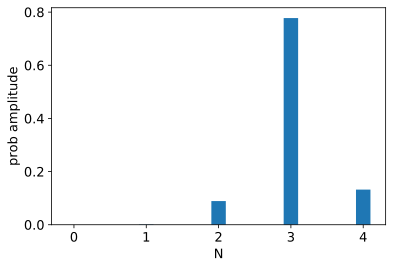

In [15]:
fig, (ax1) = plt.subplots(1,1,figsize=(6,4))

ax1.bar(range(0,len(multiplet_2orb)) ,multiplet_2orb, width=0.2)


ax1.set_xlabel(r'N')
ax1.set_ylabel(r'prob amplitude')

ax1.set_xticks(list(range(0,len(multiplet_2orb))))
        
plt.show()

Of course one could create in this way also a histogram of the spin state probability.